# [IAPR][iapr]: Lab 3 ‒  Classification


**Group ID:** 8

**Author 1 (sciper):** Luca Zunino (337560)  
**Author 2 (sciper):** Roberto Minini (336157)   
**Author 3 (sciper):** Roberto Ceraolo (343261)  

**Release date:** 07.04.2022
**Due date:** 25.04.2022


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.


[iapr]: https://github.com/LTS5/iapr

## Extract relevant data
We first need to extract the `lab-03-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-03-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

---
## Part 1
In this part, we will study classification based on the data available in the Matlab file `classification.mat` that you will under `lab-03-data/part1`.
There are 3 data sets in this file, each one being a training set for a given class.
They are contained in variables `a`, `b` and `c`.

**Note**: we can load Matlab files using the [scipy.io] module.

[scipy.io]: https://docs.scipy.org/doc/scipy/reference/io.html

In [2]:
import scipy.io

data_part1_path = os.path.join(data_base_path, data_folder, 'part1', 'classification.mat')
matfile = scipy.io.loadmat(data_part1_path)
a = matfile['a']
b = matfile['b']
c = matfile['c']

print(a.shape, b.shape, c.shape)

(200, 2) (200, 2) (200, 2)


### 1.1 Bayes method (5 pts)
Using the Bayes method, give the expression of the separation curves between those three classes.
Do reasonable hypotheses about the distributions of those classes and estimate the corresponding parameters based on the given training sets.
Draw those curves on a plot, together with the training data. Note that you do not need to solve the analytical expression. You can simply evaluate the function for each point on the plane to end up with a segmentation map.
For simplicity reasons, round the estimated parameters to the closest integer value.

#### 1.1.1 Necessary imports

In [3]:
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np

#### 1.1.2 Plotting and normality checks

We proceed to plot the points and to check whether we can assume they are normally distributed.

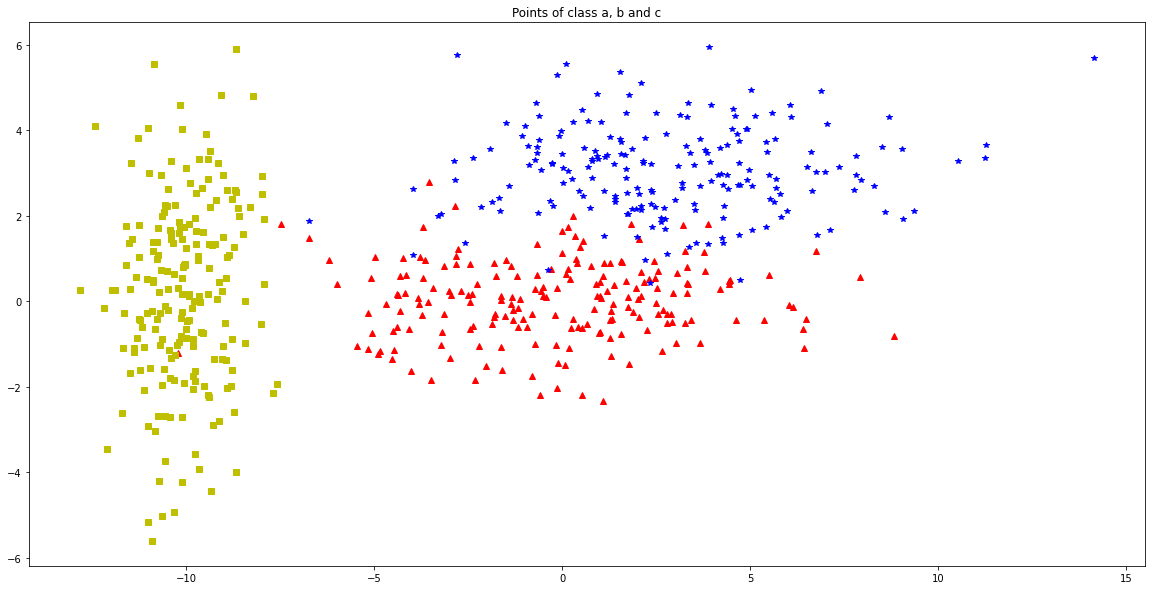

In [4]:
plt.rcParams["figure.figsize"] = (20,10)
plt.plot(a[:,0], a[:, 1], "r^")
plt.plot(b[:,0], b[:, 1], "b*")
plt.plot(c[:,0], c[:, 1], "ys")
plt.title("Points of class a, b and c")
plt.show()

In [5]:
from pingouin import multivariate_normality

In [6]:
for x in [a,b,c]:
    print(multivariate_normality(x, alpha=.05))

HZResults(hz=0.5393399744748395, pval=0.648444319366761, normal=True)
HZResults(hz=0.599051112625415, pval=0.5224272512722365, normal=True)
HZResults(hz=0.43580364906117275, pval=0.8509771218026299, normal=True)


All of the p-values are above 0.05, so we fail to reject the null hypothesis stating the data is normally distributed. Hence, we can use a normality assumption.

#### 1.1.3 Trying to implement a Gaussian Naive Bayes Classifier to check the accuracy

The data is not perfectly linearly separable, but we can envision some curves that could classify most of the datapoints. As we saw, it looks reasonable to assume a gaussian prior for the datapoints, so here we implement a Gaussian Naive Bayes classifier and check its accuracy on a 20-80 test-train split.

In [7]:
# Storing the feature matrix (X) and response vector (y)
X = np.concatenate((a, b), axis=0)
X = np.concatenate((X, c), axis=0)
y = np.repeat(1, a.shape[0])
y = np.append(y, np.repeat(2, b.shape[0]))
y = np.append(y, np.repeat(3, c.shape[0]))

In [8]:
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

# Splitting X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=1)
 
# Training the model on training set

gnb = GaussianNB()
gnb.fit(X_train, y_train)
 
# Making predictions on the testing set
y_pred = gnb.predict(X_test)
 
# Comparing actual response values (y_test) with predicted response values (y_pred)

print("Gaussian Naive Bayes model accuracy(in %):", metrics.accuracy_score(y_test, y_pred)*100)

Gaussian Naive Bayes model accuracy(in %): 97.5


As we can see, the Naive Gaussian model provides a satisfying accuracy.

#### 1.1.4 Creating the discriminant function and computing means and covariances

We now take a different approach and we plot the separation curves using the discriminant function

In [9]:
def g(x, mean, inverted_cov):
    result = 0
    result += (1/2) * np.dot(np.dot(x, inverted_cov), mean) 
    result -= (1/2)* np.dot(np.dot(mean, inverted_cov), mean) 
    result -= (1/2) * np.dot(np.dot(x, inverted_cov), x)
    result += (1/2) * np.dot(np.dot(mean, inverted_cov), x) 
    result += np.log(1/(np.sqrt(2 * np.pi) * np.sqrt(np.linalg.norm(inverted_cov))))
    return result

Now we compute the measures which we are going to need when computing the function.

In [10]:
cov_a = np.cov(a.T)
cov_b = np.cov(b.T)
cov_c = np.cov(c.T)
mean_a = np.mean(a, axis = 0)
mean_b = np.mean(b, axis = 0)
mean_c = np.mean(c, axis = 0)
inverted_cov_a = np.linalg.inv(cov_a)
inverted_cov_b  = np.linalg.inv(cov_b)
inverted_cov_c  = np.linalg.inv(cov_c)

#### 1.1.5 Computing and plotting the curves

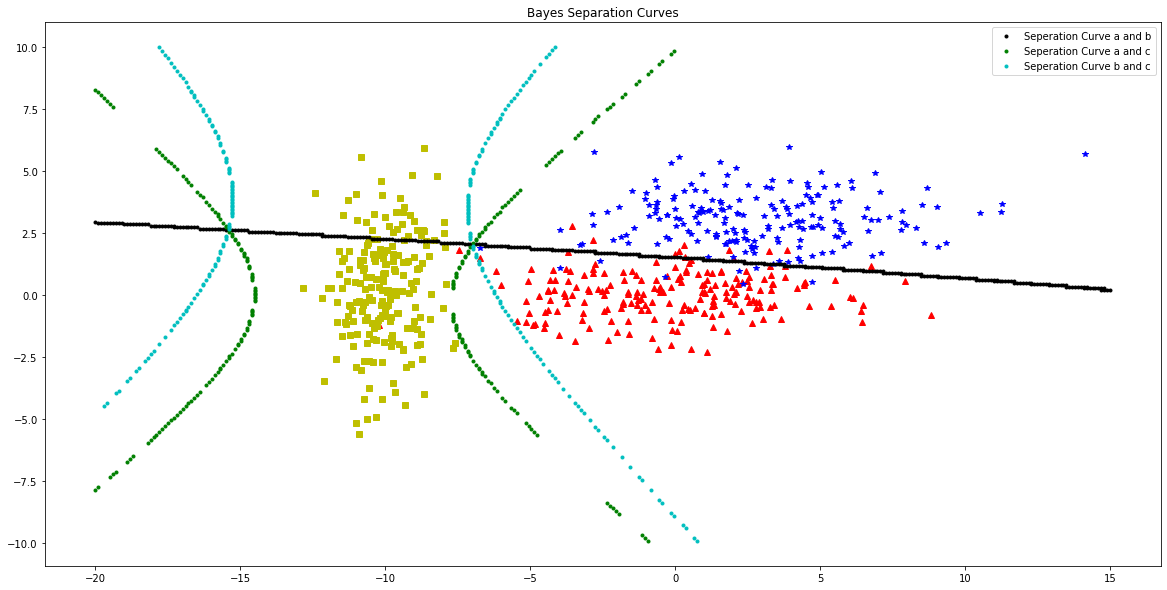

In [11]:
plt.rcParams["figure.figsize"] = (20,10)
n_points_to_plot = 350
threshold = 0.1
curve_ab = []
curve_ac = []
curve_bc = []


for x1 in np.linspace(-20, 15, n_points_to_plot):
    for x2 in np.linspace(-10, 10, n_points_to_plot):
        x = np.array([x1,x2])
        if np.abs(g(x, mean_a, inverted_cov_a) - g(x, mean_c, inverted_cov_c)) < threshold:
            curve_ac.append([x1,x2])
                
        if np.abs(g(x, mean_b, inverted_cov_b) - g(x, mean_c, inverted_cov_c) ) < threshold:
            curve_bc.append([x1,x2])
            
        if np.abs(g(x, mean_a, inverted_cov_a) - g(x, mean_b, inverted_cov_b) ) < threshold:
            curve_ab.append([x1,x2])
            
              
plt.plot(a[:,0], a[:, 1], "r^")
plt.plot(b[:,0], b[:, 1], "b*")
plt.plot(c[:,0], c[:, 1], "ys")
curve_ab = np.array(curve_ab)
curve_ac = np.array(curve_ac)
curve_bc = np.array(curve_bc)
plt.plot(curve_ab[:,0],curve_ab[:,1] , 'k.', label='Seperation Curve a and b')
plt.plot(curve_ac[:,0],curve_ac[:,1] , 'g.', label='Seperation Curve a and c')
plt.plot(curve_bc[:,0],curve_bc[:,1] , 'c.', label='Seperation Curve b and c')
plt.title("Bayes Separation Curves")
plt.legend()
plt.show()  


As we can see the results are satisfying. The separation curves separate the points well.

### 1.2 Mahalanobis distance (5 pts)
For classes `a` and `b`, give the expression of the Mahalanobis distance used to classify a point in class `a` or `b`, and verify the obtained classification, in comparison with the "complete" Bayes classification, for a few points of the plane.

The expression of the Mahalanobis distance for a point $\vec{x}$  with respect to the class *i* which contains a set of observations, is the following:
$$D_{M}(\vec{x})=\sqrt{(\vec{x}-\vec{\mu}_{i})^{\top} \mathbf{S}^{-1}(\vec{x}-\vec{\mu}_{i})}$$

Where $\vec{\mu}_{i}$ is the mean of observations of the class *i* and $\mathbf{S}$ is the covariance matrix of the set of observations

Our aim is now to verify the classification that we can obtain through the Mahalanobis distance for a few points of the plane. In order to do so, we generate 100 points randomly, we compute their distances to classes *a* and *b* and assign each point to the closest class.

Here we build two plots. In the first one, we simply show the newly generated points together with the points from the original dataset. In the second one, we show the generated points classified following the Mahalanobis distance, in comparison with the separating line that we obtained with the full naive bayes method.

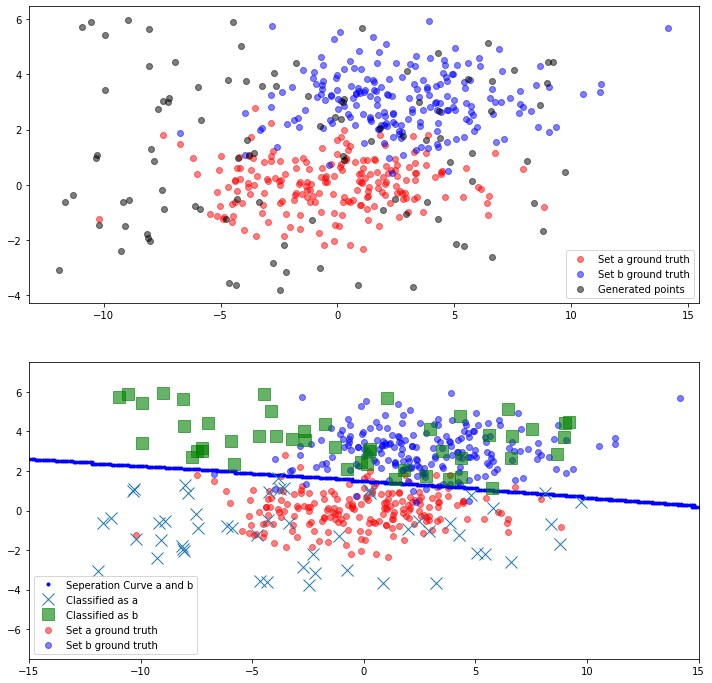

In [12]:
#Converting the Mahalanobis expression above in code:
def mahl_dist(x, mu, cov_mat_inv):
    distance = np.sqrt(np.dot(np.dot((x-mu), cov_mat_inv), (x-mu)))
    return distance


#Generating datapoints randomly. We limit x to the range [-12, 10] and y to the range [-4, 6] in order to make the "right" classes intuitively identifiable.

points = []
xs = []
ys = []
classes = [] #1 for A, 0 for B
#We artibtrarily chose that if the distances are equal, assign to class A

for i in range(100):
    x = np.random.uniform(low=-12, high=10)
    y = np.random.uniform(low=-4, high=6)
    points.append((x,y))
    xs.append(x)
    ys.append(y)
    #Computing the distances and assigning the class:
    classes.append(int(mahl_dist((x,y), mean_a, inverted_cov_a) <= mahl_dist((x,y), mean_b, inverted_cov_b)))
    


#Plotting:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.scatter(a[:,0 ], a[:,1], c="r", alpha=0.5, label = "Set a ground truth")
ax1.scatter(b[:,0 ], b[:,1], c="blue", alpha=0.5, label = "Set b ground truth")
ax1.scatter(xs, ys, c="black", alpha=0.5, label = "Generated points")

ax1.legend()
plt.ylim(-7.5,7.5)
plt.xlim(-15,15)


ax2.scatter(a[:,0 ], a[:,1], c="r", alpha=0.5, label = "Set a ground truth")
ax2.scatter(b[:,0 ], b[:,1], c="b", alpha=0.5, label = "Set b ground truth")
plt.plot(curve_ab[:,0],curve_ab[:,1] , 'b.', label='Seperation Curve a and b')


points_classified_a_xs = []
points_classified_a_ys = []

points_classified_b_xs = []
points_classified_b_ys = []
 
for ind, point in enumerate(points):
    if classes[ind]:
        points_classified_a_xs.append(point[0])
        points_classified_a_ys.append(point[1])
    else:
        points_classified_b_xs.append(point[0])
        points_classified_b_ys.append(point[1])

ax2.plot(points_classified_a_xs,points_classified_a_ys, marker='x', linestyle='', ms=12, label="Classified as a")
ax2.plot(points_classified_b_xs, points_classified_b_ys,marker='s', linestyle='', ms=12, label="Classified as b", c="green", alpha=0.6)                       


plt.legend()
plt.ylim(-7.5,7.5)
plt.xlim(-15,15)
plt.show()




As can be seen from the second graph, the classifier based on the Mahalanobis distance is yielding very similar results with respect to the ones obtained with the full Gaussian Bayes method. In the plot, the separation curve plotted is the one we obtained from the full Bayes, whereas the different symbols for the generated points show the classification done with the Mahalanobis distance.

---

## Part 2
In this part, we aim to classify digits using the complete version of MNIST digits dataset.
The dataset consists of 60'000 training images and 10'000 test images of handwritten digits.
Each image has size 28x28, and has assigned a label from zero to nine, denoting the digits value.
Given this data, your task is to construct a Multilayer Perceptron (MLP) for supervised training and classification and evaluate it on the test images.

Download the MNIST dataset (all 4 files) from http://yann.lecun.com/exdb/mnist/ under `lab-03-data/part2`.
You can then use the script provided below to extract and load training and testing images in Python. 

**! Warning**: When the lab was created the official MNIST repo was down, if it is still the case please use https://github.com/mkolod/MNIST.

### 2.1 Dataset loading
Here we first declare the methods `extract_data` and `extract_labels` so that we can reuse them later in the code.
Then we extract both the data and corresponding labels, and plot randomly some images and corresponding labels of the training set.

In [13]:
import gzip
import numpy as np
import matplotlib.pyplot as plt

def extract_data(filename, image_shape, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(16)
        buf = bytestream.read(np.prod(image_shape) * image_number)
        data = np.frombuffer(buf, dtype=np.uint8).astype(np.float32)
        data = data.reshape(image_number, image_shape[0], image_shape[1])
    return data


def extract_labels(filename, image_number):
    with gzip.open(filename) as bytestream:
        bytestream.read(8)
        buf = bytestream.read(1 * image_number)
        labels = np.frombuffer(buf, dtype=np.uint8).astype(np.int64)
    return labels

In [14]:
image_shape = (28, 28)
train_set_size = 60000
test_set_size = 10000

data_part2_folder = os.path.join(data_base_path, data_folder, 'part2')

train_images_path = os.path.join(data_part2_folder, 'train-images-idx3-ubyte.gz')
train_labels_path = os.path.join(data_part2_folder, 'train-labels-idx1-ubyte.gz')
test_images_path = os.path.join(data_part2_folder, 't10k-images-idx3-ubyte.gz')
test_labels_path = os.path.join(data_part2_folder, 't10k-labels-idx1-ubyte.gz')

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)
train_labels = extract_labels(train_labels_path, train_set_size)
test_labels = extract_labels(test_labels_path, test_set_size)

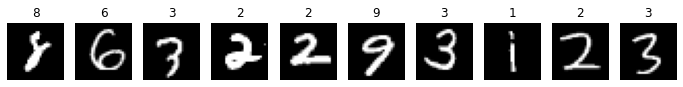

In [15]:
prng = np.random.RandomState(seed=123456789)  # seed to always re-draw the same distribution
plt_ind = prng.randint(low=0, high=train_set_size, size=10)

fig, axes = plt.subplots(1, 10, figsize=(12, 3))
for ax, im, lb in zip(axes, train_images[plt_ind], train_labels[plt_ind]):
    ax.imshow(im, cmap='gray')
    ax.axis('off')
    ax.set_title(lb)

### 2.2 MLP (10 pts)

To create an MLP you are free to choose any library.
In case you don't have any preferences, we encourage you to use the [scikit-learn] package; it is a simple, efficient and free tool for data analysis and machine learning.
In this [link][sklearn-example], you can find a basic example to see how to create and train an MLP using [scikit-learn].
Your network should have the following properties:
* Input `x`: 784-dimensional (i.e. 784 visible units representing the flattened 28x28 pixel images).
* 100 hidden units `h`.
* 10 output units `y`, i.e. the labels, with a value close to one in the i-th class representing a high probability of the input representing the digit `i`.

If you need additional examples you can borrow some code from image classification tutorials.
However, we recommend that you construct a minimal version of the network on your own to gain better insights.

[scikit-learn]: http://scikit-learn.org/stable/index.html
[sklearn-example]: http://scikit-learn.org/stable/modules/neural_networks_supervised.html

#### Trying different combinations of parameters

To create the MLP, we use the scikit-learn package and, in particular, the class 'MLPClassifier'. The Multi-layer Perceptron Classifier implemented by the class 'MLPClassifier' has many parameters that should be tuned carefully to obtain the best possible results. In particular, the main parameters that we will consider are the following (source https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier):
- hidden_layer_sizes. This parameter represents the number of neurons for each of the hidden layers. Since one of the requirements of the MLP is that it should have 100 hidden units h, this parameter will be kept fixed.
- activation. This parameter specifies the activation function for the hidden layers; the possibilities are the identity function, the logistic function, the hyperbolic tangent function and the rectified linear unit function.
- solver. This parameter specifies which solver will be used during the optimization procedure; the possibilities are stochastic gradient descent, Adam optimizer or lbfgs optimizer.
- alpha. This parameter specifies the L2 penalty or regularization term.
- learning rate. This parameter specifies how the learning rate changes during the optimization procedure; the possibilities are constant learning rate, decreasing learning rate or adaptive learning rate.
- learning_rate_init. This parameter specifies the initial learning rate.
- momentum. This parameter specifies the momentum used for the gradient descent update (used only when the solver is the stochastic gradient descent).
- nesterovs_momentum. This parameter, a flag, specifies whether to use Nesterov's momentum (used only when the solver is the stochastic gradient descent and when the momentum is bigger than zero).
- beta_1. This parameter specifies the exponential decay rate used to estimate the first moment vector by the Adam optimizer (used only when the optimizer is Adam). 
- beta_2. This parameter specifies the exponential decay rate used to estimate the second moment vector by the Adam optimizer (used only when the optimizer is Adam).

To determine which are the parameters that allow obtaining the best results, we try many different combinations; the different parameters considered are listed in 'params' in the code below. In general, the best way of proceeding is to perform a grid search, but this would have become computationally very expensive. For this reason, we have decided to test just 20 combinations of parameters.

First of all, it is necessary to introduce a measure of performance: we will consider the accuracy, defined as the number of correctly classified samples divided by the total amount of samples. The accuracy on the training set is not a reliable measure of performance, as a very high train accuracy may be due to overfitting. We will therefore consider the accuracy obtained on a validation set (on which the MLP is not trained) and use the train accuracy just to detect overfitting. To investigate performance, it is necessary to use a validation set, and not directly the MNIST test set, to avoid fine-tuning the parameters to the test set. In other words, the test set will be used just at the end of the procedure to check whether our algorithm leads to good results. Instead of splitting the MNIST train set into a train set and a validation set, we use K-fold cross-validation, and in particular, we will consider K = 10. According to Wikipedia (https://en.wikipedia.org/wiki/Cross-validation_(statistics)#k-fold_cross-validation): "In k-fold cross-validation, the original sample is randomly partitioned into k equal sized subsamples. Of the k subsamples, a single subsample is retained as the validation data for testing the model, and the remaining k − 1 subsamples are used as training data. The cross-validation process is then repeated k times, with each of the k subsamples used exactly once as the validation data. The k results can then be averaged to produce a single estimation"; this is precisely the procedure that we will use in the following.

The following code is inspired from https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mlp_training_curves.html#sphx-glr-auto-examples-neural-networks-plot-mlp-training-curves-py , profoundly changed to implement K-fold cross-validation (source: https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html), remove plots and consider different combinations of parameters.

We start reshaping the train images and the test images, flattening them (since the input is 784-dimensional, that is 784 visible units representing the flattened 28x28 pixel images). Furthermore, as stated in https://scikit-learn.org/stable/modules/neural_networks_supervised.html , "Multi-layer Perceptron is sensitive to feature scaling, so it is highly recommended to scale your data. For example, scale each attribute on the input vector X to [0, 1] or [-1, +1], or standardize it to have mean 0 and variance 1. Note that you must apply the same scaling to the test set for meaningful results. You can use StandardScaler for standardization". We, therefore, use StandardScaler to scale the data. Note that, with this specific dataset, we have verified that the obtained results are very similar if the data are not standardized. Still, we decided to standardize them in any case as this is a good practice.

In [16]:
import warnings
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning

train_images = np.reshape(train_images, (-1, image_shape[0]*image_shape[1]))
test_images = np.reshape(test_images, (-1, image_shape[0]*image_shape[1]))

scaler = StandardScaler()
scaler.fit(train_images)

train_images = scaler.transform(train_images)
test_images = scaler.transform(test_images)

We now insert in 'params' all the combinations of parameters we want to test. 'labels' contains the labels associated with the different combinations of parameters. The abbreviations used in the labels are the following:
- For what concerns the activation, 'L' stands for "logistic", 'T' stands for "tanh", 'R' stands for "relu";
- For what concerns the solvers, 'S' stands for "sgd", 'A' stands for "adam", and 'L' stands for "lbfgs";
- For what concerns alpha, 'a=X' indicates the regularization term used (X);
- For what concerns the learning rate, 'C' indicates a constant learning rate, 'D' a decreasing learning rate, 'A' an adaptive learning rate;
- For what concerns the initial learning rate, 'i=X' indicates the initial learning rate used (X);
- For what concerns the momentum, 'm=X' indicates the momentum used (X);
- For what concerns the Nesterovs's momentum, 'T' indicates that the momentum is used, 'F' that the momentum is not used;
- For what concerns the beta_1, 'b1=X' indicates the beta_1 used (X);
- For what concerns the beta_2, 'b2=X' indicates the beta_2 used (X).

Note that, in the strings of the labels, the abbreviations are in the order presented here. If a parameter is substituted by '-', this means that it is not specified in the parameter combination; this may mean that the parameter is kept to the standard value or that it is not applicable to that particular combination of parameters. Recapping, each label is of the form: activation(L/T/R) solver(S/A/L) alpha(a=X) learning_rate(C/D/A) initial_learning_rate(i=X) momentum(m=X) Nesterovs's_momentum(T/F) beta_1(b1=X) beta_2(b2=x)

In [17]:
params = [
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0,
        "learning_rate_init": 0.2,
        "alpha": 1e-5,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
        "alpha": 1e-5,
    },
    {
        "solver": "sgd",
        "learning_rate": "constant",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
        "alpha": 1e-5,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0,
        "learning_rate_init": 0.2,
        "alpha": 1e-5,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": False,
        "learning_rate_init": 0.2,
        "alpha": 1e-5,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0.9,
        "nesterovs_momentum": True,
        "learning_rate_init": 0.2,
        "alpha": 1e-5,
    },
    {
        "solver": "sgd",
        "learning_rate": "invscaling",
        "momentum": 0,
        "learning_rate_init": 0.2,
        "alpha": 1e-5,
    },
    {
        "solver": "sgd",
        "learning_rate": "adaptive",
        "momentum": 0,
        "learning_rate_init": 0.2,
        "alpha": 1e-5,
    },
    {
        "solver": "adam",
        "learning_rate_init": 0.01,
        "alpha": 1e-5,
    },
    {
        "solver": "adam",
        "learning_rate_init": 0.01,
        "alpha": 1e-5,
        "beta_1": 0.8,
        "beta_2": 0.9,
    },
    {
        "solver": "adam",
        "activation": "logistic",
        "learning_rate_init": 0.01,
        "alpha": 1e-5,
    },
    {
        "solver": "adam",
        "activation": "tanh",
        "learning_rate_init": 0.01,
        "alpha": 1e-5,
    },
    {
        "solver": "adam",
        "learning_rate_init": 0.01,
        "alpha": 1e-5,
        "beta_1": 0.99,
        "beta_2": 0.9999,
    },
    {
        "solver": "adam",
        "learning_rate_init": 0.1,
        "alpha": 1e-5,
    },
    {
        "solver": "lbfgs",
        "alpha": 1e-5,
    },
    {
        "solver": "lbfgs",
        "activation": "logistic",
        "alpha": 1e-5,
    },
    {
        "solver": "lbfgs",
        "alpha": 1e-3,
    },
    {
        "solver": "lbfgs",
        "alpha": 1e-7,
    },
    {
        "solver": "lbfgs",
        "learning_rate": "invscaling",
        "alpha": 1e-5,
    },
    {
        "solver": "lbfgs",
        "learning_rate": "adaptive",
        "alpha": 1e-5,
    },
]

labels = [
    "- S a=1e-5 C i=0.2 m=0 - - -",
    "- S a=1e-5 C i=0.2 m=0.9 F - -",
    "- S a=0.2 C i=0.2 m=0.9 T - -",
    "- S a=1e-5 D i=0.2 m=0 - - -",
    "- S a=1e-5 D i=0.2 m=0.9 F - -",
    "- S a=1e-5 D i=0.2 m=0.9 T - -",
    "- S a=1e-5 D i=0.2 m=0 - - -",
    "- S a=1e-5 A i=0.2 m=0 - - -",
    "- A a=1e-5 - i=0.01 - - - -",
    "- A a=1e-5 - i=0.01 - - b1=0.8 b2=0.9",
    "L A a=1e-5 - i=0.01 - - - -",
    "T A a=1e-5 - i=0.01 - - - -",
    "- A a=1e-5 - i=0.01 - - b1=0.99 b2=0.9999",
    "- A a=1e-5 - i=0.1 - - - -",
    "- L a=1e-5 - - - - - -",
    "L L a=1e-5 - - - - - -",
    "- L a=1e-3 - - - - - -",
    "- L a=1e-7 - - - - - -",
    "- L a=1e-5 D - - - - -",
    "- L a=1e-5 A - - - - -"
]

We now define the function 'compare_parameters', which receives the training images, the training labels, the validation images, and the validation labels (and other utility parameters). The function computes then the train score (accuracy on the train set) and the validation score (accuracy on the validation set) for the different combinations of parameters previously specified. For what concerns the MLP, we set the maximum number of iterations performed by the solver to 200, the number of hidden units to 100 and the random state to an integer value. The random state, as specified in https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier, "determines random number generation for weights and bias initialization, train-test split if early stopping is used, and batch sampling when solver='sgd' or 'adam'. Pass an int for reproducible results across multiple function calls". Note that, since some parameters combinations will not converge, we ignore all the warnings related to convergence. The train score and the validation score are computed using the method 'score' of the class 'MLPClassifier'; later on, we will also compute the validation score without using the method for higher transparency.

In [18]:
def compare_parameters(img_train, lbl_train, img_validation, lbl_validation, train_score, validation_score, K_idx):

    max_iter = 200
    
    param_idx = 0
    
    for param in params:
        mlp = MLPClassifier(random_state=1, hidden_layer_sizes=(100,), max_iter=max_iter, **param)
        
        # some parameter combinations will not converge so they are ignored here
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
            
            mlp.fit(img_train, lbl_train)

        train_score[param_idx, K_idx-1] = mlp.score(img_train, lbl_train)
        validation_score[param_idx, K_idx-1] = mlp.score(img_validation, lbl_validation)
        param_idx = param_idx + 1

Finally, we perform K-fold cross-validation (with K = 10), and we print the mean train score and the mean validation score for the different combinations of parameters. As indicated previously, the mean train score will be considered just to identify overfitting: a significant difference between the mean train score and the mean validation score may be a sign of overfitting.

Note that, since we are considering 20 different combinations of parameters, and we will consider each combination K=10 times, the following code cell takes a lot of time to execute. To speed up the procedure, it is possible to reduce K or the number of combinations of parameters we are taking into account in performance evaluation.

In [19]:
import numpy as np
from sklearn.model_selection import KFold

K = 10
kf = KFold(n_splits=K)

train_score = np.zeros((20, K))
validation_score = np.zeros((20, K))

print("Performing K-fold cross-validation with K =", K)

idx = 1

for train_index, test_index in kf.split(train_images):
    
    print("Starting iteration", idx)
    
    new_train_images, new_validation_images = train_images[train_index], train_images[test_index]
    new_train_labels, new_validation_labels = train_labels[train_index], train_labels[test_index]

    compare_parameters(new_train_images, new_train_labels, new_validation_images, new_validation_labels, train_score, validation_score, idx)

    idx = idx + 1

mean_train_score = np.mean(train_score, axis = 1)
mean_validation_score = np.mean(validation_score, axis = 1)

idx_label = 0

for label in labels:
    print("Mean train score for", label, ":", mean_train_score[idx_label])
    print("Mean validation score for", label, ":", mean_validation_score[idx_label])
    print(" ")
    idx_label = idx_label + 1

Performing K-fold cross-validation with K = 10
Starting iteration 1
Starting iteration 2
Starting iteration 3
Starting iteration 4
Starting iteration 5
Starting iteration 6
Starting iteration 7
Starting iteration 8
Starting iteration 9
Starting iteration 10
Mean train score for - S a=1e-5 C i=0.2 m=0 - - - : 0.9999944444444445
Mean validation score for - S a=1e-5 C i=0.2 m=0 - - - : 0.9704333333333335
 
Mean train score for - S a=1e-5 C i=0.2 m=0.9 F - - : 0.8712388888888889
Mean validation score for - S a=1e-5 C i=0.2 m=0.9 F - - : 0.8636333333333333
 
Mean train score for - S a=0.2 C i=0.2 m=0.9 T - - : 0.8875055555555557
Mean validation score for - S a=0.2 C i=0.2 m=0.9 T - - : 0.8805166666666666
 
Mean train score for - S a=1e-5 D i=0.2 m=0 - - - : 0.9582925925925927
Mean validation score for - S a=1e-5 D i=0.2 m=0 - - - : 0.9457833333333333
 
Mean train score for - S a=1e-5 D i=0.2 m=0.9 F - - : 0.9665944444444445
Mean validation score for - S a=1e-5 D i=0.2 m=0.9 F - - : 0.944
 


At this point, it is possible to determine which combinations of parameters allow to obtain the highest validation scores. We will then use the best combination of parameters to train the MLP, and we will finally test it on the test set (that we have not used until now).

The best mean validation score (0.9707) is obtained considering the following combination of parameters (we will use the same notation explained above): - S a=1e-5 A i=0.2 m=0 - - -. The mean train score obtained with the same parameters is 1.0, which means that all the train samples are correctly classified. As there is a gap between the mean train score and the mean validation score, there is probably a bit of overfitting, but this is not a concern since the difference between the scores is relatively small.

The parameters that we will use in the following MLP Classifier are therefore the following (all the other parameters are not specified as they have the default value):
- Solver: stochastic gradient descent ("solver": "sgd");
- Learning rate: adaptive ("learning_rate": "adaptive");
- Momentum: 0 ("momentum": 0);
- Initial learning rate: 0.2 ("learning_rate_init": 0.2);
- Regularization term (alpha): 1e-5 ("alpha": 1e-5).

#### MLP implementation considering the best parameters

We now start from the parameters that allowed us to obtain the best results on the validation set in the previous section, and we implement an MLP classifier. The first part of the algorithm is very similar to what we presented before since we reshape the train images and the test images, and we use StandardScaler to scale the data. We also save the original train images and test images before rescaling them for later use.

In [20]:
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
import numpy as np

train_images_original = extract_data(train_images_path, image_shape, train_set_size)
test_images_original = extract_data(test_images_path, image_shape, test_set_size)

train_images = extract_data(train_images_path, image_shape, train_set_size)
test_images = extract_data(test_images_path, image_shape, test_set_size)

train_images = np.reshape(train_images, (-1, image_shape[0]*image_shape[1]))
test_images = np.reshape(test_images, (-1, image_shape[0]*image_shape[1]))

scaler = StandardScaler()
scaler.fit(train_images)

train_images = scaler.transform(train_images)
test_images = scaler.transform(test_images)

We now define the MLP classifier, considering the parameters that led to the best results in the previous parts, and we train it on the train set.

In [21]:
clf = MLPClassifier(solver='sgd', learning_rate='adaptive', momentum=0, learning_rate_init=0.2, alpha=1e-5, hidden_layer_sizes=(100,), random_state=1)
                    
clf.fit(train_images, train_labels)

MLPClassifier(alpha=1e-05, learning_rate='adaptive', learning_rate_init=0.2,
              momentum=0, random_state=1, solver='sgd')

At this point, we provide the test images to the trained MLP classifier, and we obtain the predicted test labels. We then compute the number of errors made by the classifier, and we print some of the misclassified digits. In particular, we print one misclassified digit for every fifty misclassified digits.

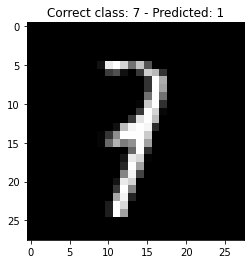

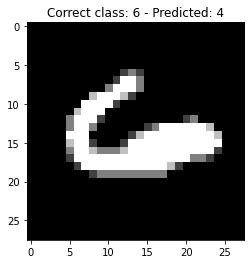

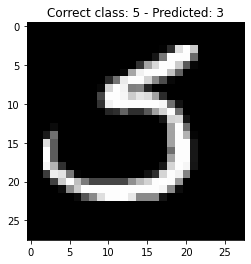

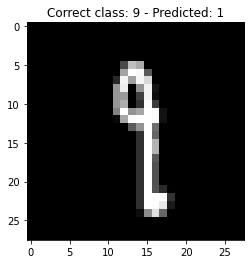

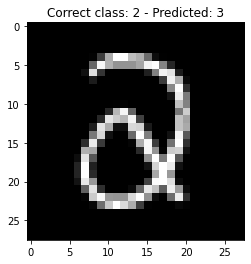

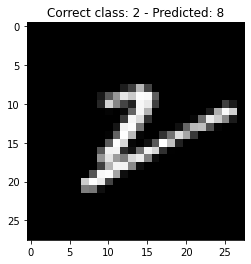

In [22]:
predicted_test_labels = clf.predict(test_images)

nb_errors = 0
for i in range(len(test_labels)):
    if predicted_test_labels[i] != test_labels[i]:
        nb_errors += 1
        if i%50 == 0:
            plt.figure(figsize=(4, 4))
            plt.imshow(test_images_original[i], cmap='gray')
            plt.title("Correct class: " + str(test_labels[i]) + " - Predicted: " + str(predicted_test_labels[i]))
            plt.show()

It is possible to see that some of the wrongly classified digits are indeed badly written, and some may even confuse humans. However, on the contrary, other misclassified digits are very clear and perfectly recognizable.

We then compute the test accuracy (test score) both starting from scratch and using the method 'score' of the class 'MLPClassifier' (the two methods provide the same result).

In [23]:
accuracy = (len(test_labels) - nb_errors)/len(test_labels)
print("Accuracy (computed from scratch) =", accuracy)

print("Accuracy (computed using the method 'score') =", clf.score(test_images, test_labels))

Accuracy (computed from scratch) = 0.9761
Accuracy (computed using the method 'score') = 0.9761


It is possible to notice that the accuracy achieved on the test set (never seen before by the MLP Classifier) is very high, as more than 97.5% of the MNIST images are correctly classified.

We can then plot the confusion matrix, which, as stated by Wikipedia (https://en.wikipedia.org/wiki/Confusion_matrix), is a "specific table layout that allows visualization of the performance of an algorithm, typically a supervised learning one [...]. Each row of the matrix represents the instances in an actual class while each column represents the instances in a predicted class, or vice versa – both variants are found in the literature. The name stems from the fact that it makes it easy to see whether the system is confusing two classes (i.e. commonly mislabeling one as another)".

We first of all print the confusion matrix in array form to show the exact numbers of correctly classified (on the main diagonal) and misclassified digits, and we then plot the confusion matrix in graphic form. Note that, since only a few of the digits are misclassified, only the diagonal cells are highlighted.

[[ 966    1    3    0    1    0    3    3    2    1]
 [   0 1126    4    0    0    1    1    1    2    0]
 [   5    4 1004    4    2    0    3    5    5    0]
 [   0    0    2  993    0    3    1    4    3    4]
 [   1    0    4    2  958    0    3    2    5    7]
 [   2    0    0   12    0  863    5    0    7    3]
 [   3    2    5    1    6    4  933    1    3    0]
 [   1    6    9    3    1    0    0  998    4    6]
 [   3    1    8    4    3    9    1    4  939    2]
 [   2    3    0    5    9    0    0    6    3  981]]


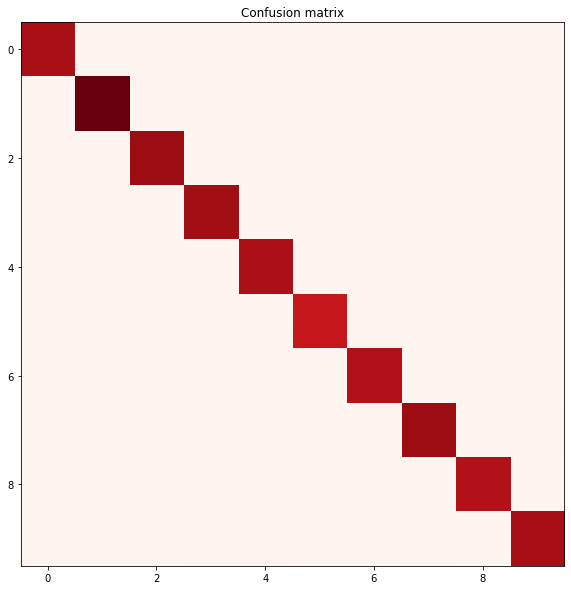

In [24]:
conf_mat = confusion_matrix(test_labels, predicted_test_labels, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
print(conf_mat)
plt.figure(figsize=(10, 10))
plt.imshow(conf_mat, cmap='Reds')
plt.title("Confusion matrix")
plt.show()

Since we are using stochastic gradient descent as the solver, we can also plot the loss as a function of epochs to determine whether the number of epochs used for training is adequate. The MLP Classifier implemented considers the standard value for the maximum number of iterations/epochs (max_iter=200). The algorithm used is the same as the one described above, adding the computation and the plotting of the loss curve. Note that also the combination of parameters is the same used before (and the one that yields the best results).

Accuracy = 0.9761


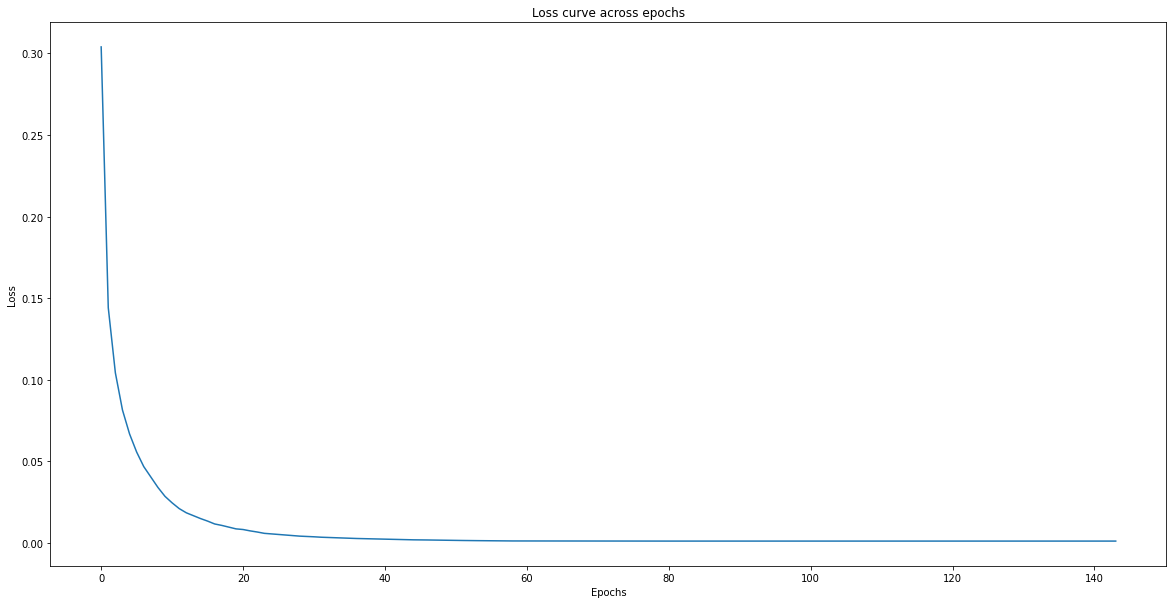

In [25]:
cl = MLPClassifier(solver='sgd', learning_rate='adaptive', momentum=0, learning_rate_init=0.2, alpha=1e-5, hidden_layer_sizes=(100,), random_state=1)

cl.fit(train_images, train_labels)

print("Accuracy =", cl.score(test_images, test_labels))

loss_curve = cl.loss_curve_
plt.plot(loss_curve)
plt.title("Loss curve across epochs")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

Considering the loss curve across epochs, it is possible to notice that the loss decreases very quickly, and a plateau is already reached at the 50th iteration. Furthermore, as specified in https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html#sklearn.neural_network.MLPClassifier , "When the loss or score is not improving by at least tol [tolerance for the optimization, whose default value is tol=1e-4] for n_iter_no_change [set to 10 by default] consecutive iterations, [...] convergence is considered to be reached and training stops". Thanks to this mechanism, the training finishes before reaching the maximum number of epochs, set to 200 by default.

As suggested by the scikit-learn documentation (https://scikit-learn.org/stable/auto_examples/neural_networks/plot_mnist_filters.html#sphx-glr-auto-examples-neural-networks-plot-mnist-filters-py), it is possible to visualize the MLP weights as they can help to understand the learning behaviour. In particular, using (and adapting) the code provided in the documentation, we will plot some of the first layer weights of the MPC Classifier (whose parameters are the same as indicated above).

Training set score: 1.000000
Test set score: 0.976100


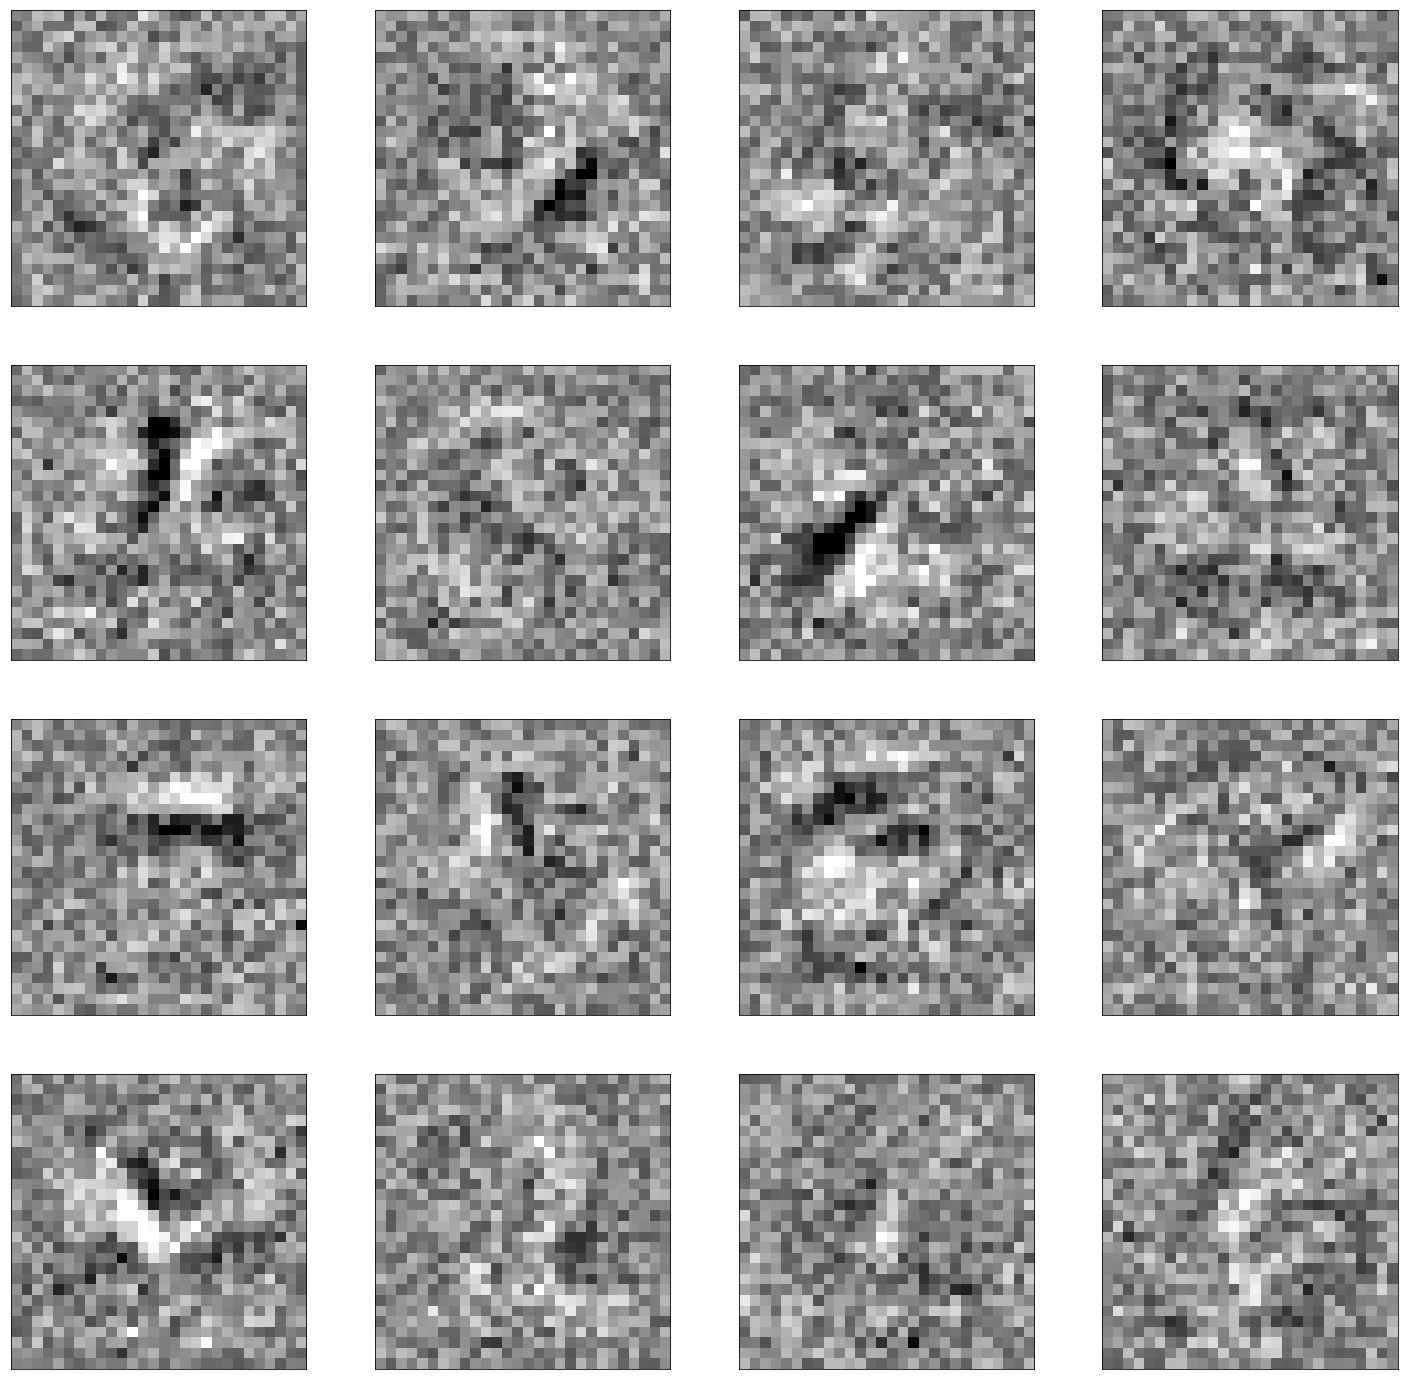

In [26]:
import warnings
import matplotlib.pyplot as plt
from sklearn.exceptions import ConvergenceWarning
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(solver='sgd', learning_rate='adaptive', momentum=0, learning_rate_init=0.2, alpha=1e-5, hidden_layer_sizes=(100,), random_state=1)

with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning, module="sklearn")
    mlp.fit(train_images, train_labels)

print("Training set score: %f" % mlp.score(train_images, train_labels))
print("Test set score: %f" % mlp.score(test_images, test_labels))

fig, axes = plt.subplots(4, 4 ,figsize=(25, 25))
# use global min / max to ensure all weights are shown on the same scale
vmin, vmax = mlp.coefs_[0].min(), mlp.coefs_[0].max()
for coef, ax in zip(mlp.coefs_[0].T, axes.ravel()):
    ax.matshow(coef.reshape(28, 28), cmap=plt.cm.gray, vmin=0.5 * vmin, vmax=0.5 * vmax)
    ax.set_xticks(())
    ax.set_yticks(())

plt.show()

Although it is not easy to interpret the weights, we can verify that they seem reasonable. Indeed, they seem to encode parts of the digits, and each of them concentrates on a particular shape. Some concentrate more on roundish shapes, others on corners or straight lines.